# <font color='red'>Backtest vectorizado para una estrategia 'Regresion lineal' definida.</font>

### Hackeado by J3viton (learning BackTesting 2021).

---

En este notebook vamos a automatizar el backtesting para estrategias. Previamente tenemos que definir **la estrategia** usando el template (import estrategia_XX as rg), donde definimos la clase estrategia que contiene los metodos de analisis, entreda y salida de mercado. Este módulo se programa y adapta para cada estrategia. Luego en el metodo 'analisis' se crea un fichero excel con las metricas y rendimientos para evaluar la estrategia.

Vamos a usar el módulo Pandas, para realizar un backtest vectorizado, es decir calcular el resultado del backtest sin iterar sobre las filas (barras) de la serie temporal.

Posteriormente graficamos y mostramos los parametros generales que nos permiten analizar la estrategia.

#### J3Viton  2021

link a la base:

https://github.com/Python-para-Trading/Webinars-Docs/blob/master/Webinar%202/Webinar%202%20-%20Backtest%20con%20Pandas%20v%202.ipynb.

---

# DEFINICION DEL SISTEMA

Como es usual, importamos los módulos que vamos a necesitar para las distintas tareas, y preparamos Matplotlib para una mejor visualización de los gráficos en el notebook.

Se importa un modulo llamado analisis, en realidad se trata de un archivo .py con algunas funciones de apoyo para el trabajo, debe estar guardado en la misma carpeta que este notebook.
Se importa el módulo 'estrategia_XX', donde se define la estrategia de entreda y salida

Es importante tener clara la lógica del sistema, pues debemos plasmarla de forma sencilla y correcta en el dataframe para realizar el backtest del mismo.


In [1]:
import analisis
import regresionAMedia as rg  #cambiar segun el módulo con la estrategia implementado
import pandas as pd
import datetime as dt
from time import time
import yfinance as yf
import numpy as np

{'id': 1473252352, 'first_name': 'vital_bot', 'is_bot': True, 'username': 'vital_quant_bot', 'can_join_groups': True, 'can_read_all_group_messages': False, 'supports_inline_queries': False}


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

***0.- RECOGIDA DE DATOS INICIALES***
Introducimos el instrumento y las fechas


In [3]:
instrumento_ = 'ANTM'   # ticker del valor en yahooFinance

Fecha_Cominezo_Backtesting = dt.datetime(2015,1,2)
Fecha_Final_Backtesting    = dt.datetime(2021,11,18)
Fecha_Final_Backtesting    = dt.datetime.today()




***1.- Rango fechas a analizar***

Definimos el rango global de datos historicos que vamos a evaluar.
Definimos la ventana que vamos a ir desplazando por todo el espectro para ir analilazando como se comporta la estrategia. La funion 'analisis' nos vale para tiempo real y para backtesting, para back le pasamos la ventana como si la fecha de fin de la ventana fuera la fecha de hoy.
Tener en cuenta que la 'ventana' tiene uqe tener una anchura que nos permita hacer los calculos en rolling (ejemplo EMA 200)

In [4]:
# Rango completo para backTesting
#start2 =dt.datetime(2008,1,2)
start2= Fecha_Cominezo_Backtesting 
#end2   =dt.datetime(2021,11,18)
end2= Fecha_Final_Backtesting 
start_G= start2.strftime("%Y-%m-%d")
end_G  =   end2.strftime("%Y-%m-%d")
TOTAL_len= (end2-start2).days
print('Tamaño timeseries global a analizar:  ', TOTAL_len, 'sesiones')

#ventana de analisis 200 sesiones
startWindow2 = start2  #dt.datetime(2008,1,5)
endWindow2   =startWindow2 + dt.timedelta(days=500) #ventana grande para que se puedan hacer los calculos de EMA200
startWindow= startWindow2.strftime("%Y-%m-%d")
endWindow  =   endWindow2.strftime("%Y-%m-%d")
window_len= (endWindow2-startWindow2).days
print('Tamaño de la ventana a analizar paso a paso:  ', window_len, 'sesiones')

Tamaño timeseries global a analizar:   2702 sesiones
Tamaño de la ventana a analizar paso a paso:   500 sesiones


In [5]:
 #dff = pd.DataFrame(columns=('Close','Volume', 'Senal', 'Dif_Close', 'Retornos','Capital'))

***2.- Descargamos los datos para el marco Global***

In [6]:
instrumento = instrumento_  # 'rovi.mc'  #Vamos título a título. Mejora: Conjunto de títulos

In [7]:
dff = yf.download(instrumento, start_G,end_G)

[*********************100%***********************]  1 of 1 completed


In [8]:
dff.dropna(inplace=True)  
dff.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,126.650002,127.730003,124.400002,125.459999,113.248199,1181600
2015-01-05,124.300003,125.459999,122.860001,123.260002,111.262360,1550000
2015-01-06,125.019997,126.940002,124.269997,124.940002,112.778801,2117000
2015-01-07,125.139999,127.900002,125.139999,125.559998,113.338455,1578500
2015-01-08,126.019997,131.800003,126.019997,131.550003,118.745430,1967400


***3.- Creamos la clase strategy que tiene toda la lógica***

In [9]:
regreMedia= rg.StrategyClass(back=True)    #Creamos la clase

***4.- Recorremos el dataframe con valores buscando las señales de la estrategia***

In [10]:
dff.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-05-13', '2022-05-16', '2022-05-17', '2022-05-18',
               '2022-05-19', '2022-05-20', '2022-05-23', '2022-05-24',
               '2022-05-25', '2022-05-26'],
              dtype='datetime64[ns]', name='Date', length=1864, freq=None)

## Proceso de backTesting ##

En este 'for' vamos recorriendo la muestra del historico de datos (TOTAL), desplazando una sesión hacia el futuro 
en cada iteracion. Vamos pasando la movilola del pasado sesión a sesión por el análisis descrito en Strategy class.

Ouput:
El sistema registra los siguientes parámetros:

.-
.-
.-


In [11]:
startWindow

'2015-01-02'

In [12]:
tiempo_inicial = time()   # Tomamos tiempos para ver cuanto tarda en hacer la estrategia

In [13]:
dfe = pd.DataFrame({'A' : []})   #df empty

***En este 'for' desplazamos la ventana sesión a sesión a lo largo de todo el rango de fechas. Dejamos que las funciones de la clase estrategia hagan el trabajo de comprar//vender y anotar***


In [14]:
#Para pruebas
#TOTAL_len =1000

for i in range(TOTAL_len):
    endWindow3   =endWindow2 + dt.timedelta(days=i) 
    endWindow    =endWindow3.strftime("%Y-%m-%d")
    print ('end date:', endWindow)
    
    if(endWindow in dff.index):
        df_aux= dff.loc[startWindow:endWindow]       #voy pasando los datos desplazando la ventana
        
        recogo = regreMedia.analisis(instrumento, startWindow, endWindow, df_aux) #Llamada a la clase estrategia. LA CLAVE DE TODO!!!
        
        print ('................................................Analizando, muestra', i, 'de', TOTAL_len, 'fecha', endWindow)
        
            
    else:
        print('..............Día sin sesión, next please')

        

end date: 2016-05-16
 Datos desde archivo
Coefficients: 
 [-0.04763394]
Independent term: 
 152.7880231535334
Coefficients: 
 [-0.04576919]
Independent term: 
 143.679035048983
Coefficients: 
 [-0.06057939]
Independent term: 
 146.22927940849436
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 0 de 2702 fecha 2016-05-16
end date: 2016-05-17
 Datos desde archivo
Coefficients: 
 [-0.04764115]
Independent term

 Datos desde archivo
Coefficients: 
 [-0.04924443]
Independent term: 
 152.97589883310806
Coefficients: 
 [-0.03414372]
Independent term: 
 141.53940067462068
Coefficients: 
 [-0.05533006]
Independent term: 
 145.96662509073892
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 15 de 2702 fecha 2016-05-31
end date: 2016-06-01
 Datos desde archivo
Coefficients: 
 [-0.04938531]
Independent term: 
 152.992522731

 Datos desde archivo
Coefficients: 
 [-0.05052059]
Independent term: 
 153.12852944563193
Coefficients: 
 [-0.02919928]
Independent term: 
 140.34537865140544
Coefficients: 
 [-0.05202276]
Independent term: 
 145.79006845971477
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 29 de 2702 fecha 2016-06-14
end date: 2016-06-15
 Datos desde archivo
Coefficients: 
 [-0.05070278]
Independent term: 
 153.150634213

Coefficients: 
 [-0.03222734]
Independent term: 
 139.98102067178755
Coefficients: 
 [-0.05005472]
Independent term: 
 145.67860073951172
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 43 de 2702 fecha 2016-06-28
end date: 2016-06-29
 Datos desde archivo
Coefficients: 
 [-0.05268407]
Independent term: 
 153.39523169980765
Coefficients: 
 [-0.03164635]
Independent term: 
 139.8512626112753
Coefficients: 
 

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 57 de 2702 fecha 2016-07-12
end date: 2016-07-13
 Datos desde archivo
Coefficients: 
 [-0.05329915]
Independent term: 
 153.47270907512478
Coefficients: 
 [-0.02200677]
Independent term: 
 138.15082365121415
Coefficients: 
 [-0.04907852]
Independent term: 
 145.61999358798647
  Instrumento  long_short_out                    date      precio  beneficio  \
0   

 Datos desde archivo
Coefficients: 
 [-0.05212637]
Independent term: 
 153.32055980369842
Coefficients: 
 [-0.01674428]
Independent term: 
 137.5078560649815
Coefficients: 
 [-0.04833323]
Independent term: 
 145.57284674063058
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 70 de 2702 fecha 2016-07-25
end date: 2016-07-26
 Datos desde archivo
Coefficients: 
 [-0.05194304]
Independent term: 
 153.2966055676

 Datos desde archivo
Coefficients: 
 [-0.05310894]
Independent term: 
 153.4514226009754
Coefficients: 
 [-0.01198991]
Independent term: 
 136.31214558046256
Coefficients: 
 [-0.04604786]
Independent term: 
 145.09816040390695
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 84 de 2702 fecha 2016-08-08
end date: 2016-08-09
 Datos desde archivo
Coefficients: 
 [-0.0532409]
Independent term: 
 153.46910511796

 Datos desde archivo
Coefficients: 
 [-0.05400794]
Independent term: 
 153.572995748713
Coefficients: 
 [-0.01246679]
Independent term: 
 135.81204572421402
Coefficients: 
 [-0.04279849]
Independent term: 
 144.22937570608536
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 98 de 2702 fecha 2016-08-22
end date: 2016-08-23
 Datos desde archivo
Coefficients: 
 [-0.05408294]
Independent term: 
 153.58329621951

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 109 de 2702 fecha 2016-09-02
end date: 2016-09-03
..............Día sin sesión, next please
end date: 2016-09-04
..............Día sin sesión, next please
end date: 2016-09-05
..............Día sin sesión, next please
end date: 2016-09-06
 Datos desde archivo
Coefficients: 
 [-0.05581124]
Independent term: 
 153.8237129427352
Coefficients: 
 [-0.02509142]
Ind

 Datos desde archivo
Coefficients: 
 [-0.05697463]
Independent term: 
 153.98900443817692
Coefficients: 
 [-0.03947581]
Independent term: 
 137.78589324495684
Coefficients: 
 [-0.03994762]
Independent term: 
 142.94156710695248
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 126 de 2702 fecha 2016-09-19
end date: 2016-09-20
 Datos desde archivo
Coefficients: 
 [-0.05709008]
Independent term: 
 154.00559089

 Datos desde archivo
Coefficients: 
 [-0.05787811]
Independent term: 
 154.12040313413354
Coefficients: 
 [-0.05073278]
Independent term: 
 138.5222110304192
Coefficients: 
 [-0.04054979]
Independent term: 
 142.49925448065616
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 140 de 2702 fecha 2016-10-03
end date: 2016-10-04
 Datos desde archivo
Coefficients: 
 [-0.05806413]
Independent term: 
 154.147748836

 [-0.05950856]
Independent term: 
 154.36228576446678
Coefficients: 
 [-0.05625121]
Independent term: 
 138.26134528886027
Coefficients: 
 [-0.0417228]
Independent term: 
 142.14879259844437
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 151 de 2702 fecha 2016-10-14
end date: 2016-10-15
..............Día sin sesión, next please
end date: 2016-10-16
..............Día sin sesión, next please
end date: 2016-

Coefficients: 
 [-0.06362559]
Independent term: 
 138.42559576689305
Coefficients: 
 [-0.04328666]
Independent term: 
 141.81357507620177
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 164 de 2702 fecha 2016-10-27
end date: 2016-10-28
 Datos desde archivo
Coefficients: 
 [-0.06065199]
Independent term: 
 154.53525181935902
Coefficients: 
 [-0.0642837]
Independent term: 
 138.40867769611418
Coefficients: 


  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 177 de 2702 fecha 2016-11-09
end date: 2016-11-10
 Datos desde archivo
Coefficients: 
 [-0.06123914]
Independent term: 
 154.62515369647403
Coefficients: 
 [-0.06904749]
Independent term: 
 138.33737475039354
Coefficients: 
 [-0.04558826]
Independent term: 
 141.48640943406372
  Instrumento  long_short_out                    date      precio  beneficio  \
0  

 Datos desde archivo
Coefficients: 
 [-0.05875898]
Independent term: 
 154.23439396369145
Coefficients: 
 [-0.06971362]
Independent term: 
 138.9030550202327
Coefficients: 
 [-0.04733405]
Independent term: 
 141.25594686241237
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 190 de 2702 fecha 2016-11-22
end date: 2016-11-23
 Datos desde archivo
Coefficients: 
 [-0.05830302]
Independent term: 
 154.161896292

 Datos desde archivo
Coefficients: 
 [-0.05468353]
Independent term: 
 153.58103538884546
Coefficients: 
 [-0.0625484]
Independent term: 
 139.00631567769977
Coefficients: 
 [-0.04902827]
Independent term: 
 141.0741342110855
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 204 de 2702 fecha 2016-12-06
end date: 2016-12-07
 Datos desde archivo
Coefficients: 
 [-0.05422467]
Independent term: 
 153.5066998125

 Datos desde archivo
Coefficients: 
 [-0.05065701]
Independent term: 
 152.92353783816267
Coefficients: 
 [-0.04699528]
Independent term: 
 138.0496795950363
Coefficients: 
 [-0.04943307]
Independent term: 
 140.85045903977922
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 217 de 2702 fecha 2016-12-19
end date: 2016-12-20
 Datos desde archivo
Coefficients: 
 [-0.05017551]
Independent term: 
 152.844090390

 Datos desde archivo
Coefficients: 
 [-0.04704027]
Independent term: 
 152.322207356227
Coefficients: 
 [-0.02265285]
Independent term: 
 135.84760824061152
Coefficients: 
 [-0.04810544]
Independent term: 
 140.51316224775096
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 232 de 2702 fecha 2017-01-03
end date: 2017-01-04
 Datos desde archivo
Coefficients: 
 [-0.04670154]
Independent term: 
 152.2653005083

Coefficients: 
 [-0.04357841]
Independent term: 
 151.73578089199978
Coefficients: 
 [0.00207148]
Independent term: 
 133.63458706300648
Coefficients: 
 [-0.04476969]
Independent term: 
 140.00800646492843
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 246 de 2702 fecha 2017-01-17
end date: 2017-01-18
 Datos desde archivo
Coefficients: 
 [-0.04317463]
Independent term: 
 151.66673409743404
Coefficients: 


 Datos desde archivo
Coefficients: 
 [-0.03931556]
Independent term: 
 151.00086318654363
Coefficients: 
 [0.03833301]
Independent term: 
 130.36071553130648
Coefficients: 
 [-0.03901525]
Independent term: 
 139.30077164369965
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 259 de 2702 fecha 2017-01-30
end date: 2017-01-31
 Datos desde archivo
Coefficients: 
 [-0.03879863]
Independent term: 
 150.910917626

 Datos desde archivo
Coefficients: 
 [-0.03395345]
Independent term: 
 150.06056342792007
Coefficients: 
 [0.08571436]
Independent term: 
 126.26077060984142
Coefficients: 
 [-0.03014058]
Independent term: 
 138.33993704196357
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 270 de 2702 fecha 2017-02-10
end date: 2017-02-11
..............Día sin sesión, next please
end date: 2017-02-12
..............Día sin

 Datos desde archivo
Coefficients: 
 [-0.02826733]
Independent term: 
 149.0466336839646
Coefficients: 
 [0.12948676]
Independent term: 
 122.95776718481261
Coefficients: 
 [-0.01798767]
Independent term: 
 137.1324466401948
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 284 de 2702 fecha 2017-02-24
end date: 2017-02-25
..............Día sin sesión, next please
end date: 2017-02-26
..............Día sin s

 Datos desde archivo
Coefficients: 
 [-0.02261701]
Independent term: 
 148.02213376323257
Coefficients: 
 [0.16831417]
Independent term: 
 120.43928981951811
Coefficients: 
 [-0.00335084]
Independent term: 
 135.78245381009512
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 297 de 2702 fecha 2017-03-09
end date: 2017-03-10
 Datos desde archivo
Coefficients: 
 [-0.02200888]
Independent term: 
 147.910846331

 Datos desde archivo
Coefficients: 
 [-0.01720772]
Independent term: 
 147.0251213742984
Coefficients: 
 [0.19884885]
Independent term: 
 119.01983916439227
Coefficients: 
 [0.01289101]
Independent term: 
 134.39553389773548
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 310 de 2702 fecha 2017-03-22
end date: 2017-03-23
 Datos desde archivo
Coefficients: 
 [-0.01667345]
Independent term: 
 146.92574850407

 Datos desde archivo
Coefficients: 
 [-0.0126577]
Independent term: 
 146.17271955715742
Coefficients: 
 [0.22313793]
Independent term: 
 118.08177632346082
Coefficients: 
 [0.03009266]
Independent term: 
 133.02302983553662
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 323 de 2702 fecha 2017-04-04
end date: 2017-04-05
 Datos desde archivo
Coefficients: 
 [-0.01218102]
Independent term: 
 146.08262732299

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 337 de 2702 fecha 2017-04-18
end date: 2017-04-19
 Datos desde archivo
Coefficients: 
 [-0.0078203]
Independent term: 
 145.25127839678782
Coefficients: 
 [0.24318102]
Independent term: 
 117.93243800035164
Coefficients: 
 [0.04956208]
Independent term: 
 131.58945755320633
  Instrumento  long_short_out                    date      precio  beneficio  \
0     

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 350 de 2702 fecha 2017-05-01
end date: 2017-05-02
 Datos desde archivo
Coefficients: 
 [-0.00256468]
Independent term: 
 144.2328981927981
Coefficients: 
 [0.27133516]
Independent term: 
 117.04350202190344
Coefficients: 
 [0.06742893]
Independent term: 
 130.38305967370454
  Instrumento  long_short_out                    date      precio  beneficio  \
0     

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 361 de 2702 fecha 2017-05-12
end date: 2017-05-13
..............Día sin sesión, next please
end date: 2017-05-14
..............Día sin sesión, next please
end date: 2017-05-15
 Datos desde archivo
Coefficients: 
 [0.0030898]
Independent term: 
 143.12086960865005
Coefficients: 
 [0.30774245]
Independent term: 
 115.39837678026797
Coefficients: 
 [0.08674968]


  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 374 de 2702 fecha 2017-05-25
end date: 2017-05-26
 Datos desde archivo
Coefficients: 
 [0.00800279]
Independent term: 
 142.13983386968124
Coefficients: 
 [0.3245079]
Independent term: 
 116.01771433474413
Coefficients: 
 [0.10658582]
Independent term: 
 127.99762914152345
  Instrumento  long_short_out                    date      precio  beneficio  \
0      

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 388 de 2702 fecha 2017-06-08
end date: 2017-06-09
 Datos desde archivo
Coefficients: 
 [0.0135715]
Independent term: 
 141.0111991351958
Coefficients: 
 [0.34702553]
Independent term: 
 116.34611024429549
Coefficients: 
 [0.12643405]
Independent term: 
 126.98101210243857
  Instrumento  long_short_out                    date      precio  beneficio  \
0      I

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 401 de 2702 fecha 2017-06-21
end date: 2017-06-22
 Datos desde archivo
Coefficients: 
 [0.01916491]
Independent term: 
 139.8606766545194
Coefficients: 
 [0.3614928]
Independent term: 
 117.83321744890354
Coefficients: 
 [0.14613785]
Independent term: 
 126.13247824722308
  Instrumento  long_short_out                    date      precio  beneficio  \
0      I

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 415 de 2702 fecha 2017-07-05
end date: 2017-07-06
 Datos desde archivo
Coefficients: 
 [0.02409928]
Independent term: 
 138.83107733848078
Coefficients: 
 [0.36741106]
Independent term: 
 120.07959985989243
Coefficients: 
 [0.16501422]
Independent term: 
 125.52022467552273
  Instrumento  long_short_out                    date      precio  beneficio  \
0     

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 428 de 2702 fecha 2017-07-18
end date: 2017-07-19
 Datos desde archivo
Coefficients: 
 [0.02897776]
Independent term: 
 137.798644897727
Coefficients: 
 [0.37021807]
Independent term: 
 122.74025245211018
Coefficients: 
 [0.18266896]
Independent term: 
 125.17103351749786
  Instrumento  long_short_out                    date      precio  beneficio  \
0      I

................................................Analizando, muestra 451 de 2702 fecha 2017-08-10
end date: 2017-08-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 452 de 2702 fecha 2017-08-11
end date: 2017-08-12
..............Día sin sesión, next please
end date: 2017-08-13
..............Día sin sesión, next please
end date: 2017-08-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 455 de 2702 fecha 2017-08-14
end date: 2017-08-15
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 456 de 2702 fecha 2017-08-15
end date: 2017-08-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 457 de 2702 fecha 2017-08-16
end date: 2017-08-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 458 de 2702 fecha 201

................................................Analizando, muestra 515 de 2702 fecha 2017-10-13
end date: 2017-10-14
..............Día sin sesión, next please
end date: 2017-10-15
..............Día sin sesión, next please
end date: 2017-10-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 518 de 2702 fecha 2017-10-16
end date: 2017-10-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 519 de 2702 fecha 2017-10-17
end date: 2017-10-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 520 de 2702 fecha 2017-10-18
end date: 2017-10-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 521 de 2702 fecha 2017-10-19
end date: 2017-10-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 522 de 2702 fecha 201

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2017-07-26 00:00:00.000  184.990005  12.801249   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   6.261634  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 539 de 2702 fecha 2017-11-06
end date: 2017-11-07
 Datos desde archivo
Coefficients: 
 [0.05777855]
Independent term: 
 131.30541340638268
Coefficients: 
 [0.21519444]
Independent term: 
 160.2348038835668
Coefficients: 
 [0.2329097]
Independent term: 
 136.10127480913644
  Instrumento  long_short_out                    date      precio  beneficio  \
0      I

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2017-07-26 00:00:00.000  184.990005  12.801249   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   6.261634  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 550 de 2702 fecha 2017-11-17
end date: 2017-11-18
..............Día sin sesión, next please
end date: 2017-11-19
..............Día sin sesión, next please
end date: 2017-11-20
 Datos desde archivo
Coefficients: 
 [0.06236071]
Independent term: 
 130.20262538428784
Coefficients: 
 [0.22634185]
Independent term: 
 161.9522862015909
Coefficients: 
 [0.2318681]
I

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2017-07-26 00:00:00.000  184.990005  12.801249   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   6.261634  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 564 de 2702 fecha 2017-12-01
end date: 2017-12-02
..............Día sin sesión, next please
end date: 2017-12-03
..............Día sin sesión, next please
end date: 2017-12-04
 Datos desde archivo
Coefficients: 
 [0.06716485]
Independent term: 
 129.03177485421978
Coefficients: 
 [0.2461468]
Independent term: 
 162.821493379963
Coefficients: 
 [0.23223938]
In

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2017-07-26 00:00:00.000  184.990005  12.801249   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   6.261634  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 577 de 2702 fecha 2017-12-14
end date: 2017-12-15
 Datos desde archivo
Coefficients: 
 [0.07169967]
Independent term: 
 127.9131191595427
Coefficients: 
 [0.26453086]
Independent term: 
 163.74697944071755
Coefficients: 
 [0.23428439]
Independent term: 
 142.33835151475662
  Instrumento  long_short_out                    date      precio  beneficio  \
0      

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2017-07-26 00:00:00.000  184.990005  12.801249   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   6.261634  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 591 de 2702 fecha 2017-12-28
end date: 2017-12-29
 Datos desde archivo
Coefficients: 
 [0.07587112]
Independent term: 
 126.87179500652414
Coefficients: 
 [0.27814392]
Independent term: 
 165.0734800446923
Coefficients: 
 [0.23759222]
Independent term: 
 144.2424951053282
  Instrumento  long_short_out                    date      precio  beneficio  \
0      I

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2017-07-26 00:00:00.000  184.990005  12.801249   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   6.261634  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 605 de 2702 fecha 2018-01-11
end date: 2018-01-12
 Datos desde archivo
Coefficients: 
 [0.08028964]
Independent term: 
 125.75519481009249
Coefficients: 
 [0.29141992]
Independent term: 
 166.7810184581244
Coefficients: 
 [0.2417192]
Independent term: 
 146.11329428185883
  Instrumento  long_short_out                    date      precio  beneficio  \
0      I

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2017-07-26 00:00:00.000  184.990005  12.801249   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   6.261634  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 619 de 2702 fecha 2018-01-25
end date: 2018-01-26
 Datos desde archivo
Coefficients: 
 [0.08592254]
Independent term: 
 124.31489763835916
Coefficients: 
 [0.32040423]
Independent term: 
 167.68552906548797
Coefficients: 
 [0.24734969]
Independent term: 
 147.93769819793653
  Instrumento  long_short_out                    date      precio  beneficio  \
0     

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2017-07-26 00:00:00.000  184.990005  12.801249   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   6.261634  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 632 de 2702 fecha 2018-02-07
end date: 2018-02-08
 Datos desde archivo
Coefficients: 
 [0.09024417]
Independent term: 
 123.19765677151503
Coefficients: 
 [0.32793743]
Independent term: 
 170.2232260723968
Coefficients: 
 [0.25423834]
Independent term: 
 149.74628568326472
  Instrumento  long_short_out                    date      precio  beneficio  \
0      

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2017-07-26 00:00:00.000  184.990005  12.801249   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   6.261634  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 646 de 2702 fecha 2018-02-21
end date: 2018-02-22
 Datos desde archivo
Coefficients: 
 [0.0935698]
Independent term: 
 122.32751360696946
Coefficients: 
 [0.33400428]
Independent term: 
 172.03112443155317
Coefficients: 
 [0.26089732]
Independent term: 
 151.5946732148382
  Instrumento  long_short_out                    date      precio  beneficio  \
0      I

Coefficients: 
 [0.09638456]
Independent term: 
 121.58316107765458
Coefficients: 
 [0.33580239]
Independent term: 
 174.0423124626501
Coefficients: 
 [0.26669879]
Independent term: 
 153.2445005699032
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2017-07-26 00:00:00.000  184.990005  12.801249   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   6.261634  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 659 de 2702 fecha 2018-03-06
end date: 2018-03-07
 Datos desde archivo
Coefficients: 
 [0.09669604]
Independent term: 
 121.5003086153666
Coefficients: 
 [0.33

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 700 de 2702 fecha 2018-04-16
end date: 2018-04-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 701 de 2702 fecha 2018-04-17
end date: 2018-04-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 702 de 2702 fecha 2018-04-18
end date: 2018-04-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 703 de 2702 fecha 2018-04-19
end date: 2018-04-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 704 de 2702 fecha 2018-04-20
end date: 2018-04-21
..............Día sin sesión, next please
end date: 2018-04-22
..............Día sin sesión, next please
end date: 2018-04-23
aqui estoy en out
 datos desde archivo
................................................An

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 763 de 2702 fecha 2018-06-18
end date: 2018-06-19
 Datos desde archivo
Coefficients: 
 [0.11069508]
Independent term: 
 117.61750993813124
Coefficients: 
 [0.21382115]
Independent term: 
 200.7496452764255
Coefficients: 
 [0.27070155]
Independent term: 
 171.45679914454487
  Instrumento  long_short_out                    date      precio  beneficio  \
0      

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 774 de 2702 fecha 2018-06-29
end date: 2018-06-30
..............Día sin sesión, next please
end date: 2018-07-01
..............Día sin sesión, next please
end date: 2018-07-02
 Datos desde archivo
Coefficients: 
 [0.11254028]
Independent term: 
 117.07950743866598
Coefficients: 
 [0.19778484]
Independent term: 
 204.526058891638
Coefficients: 
 [0.26524527]
I

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 788 de 2702 fecha 2018-07-13
end date: 2018-07-14
..............Día sin sesión, next please
end date: 2018-07-15
..............Día sin sesión, next please
end date: 2018-07-16
 Datos desde archivo
Coefficients: 
 [0.11455111]
Independent term: 
 116.48680907991844
Coefficients: 
 [0.1697446]
Independent term: 
 210.1309619231722
Coefficients: 
 [0.25801547]
I

 Datos desde archivo
Coefficients: 
 [0.11625468]
Independent term: 
 115.98003194408028
Coefficients: 
 [0.14959172]
Independent term: 
 214.37337377292008
Coefficients: 
 [0.25036281]
Independent term: 
 179.75771424273694
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 801 de 2702 fecha 2018-07-26
end date: 2018-07-27
 Datos desde archivo
Coefficients: 
 [0.1164705]
Independent term: 
 115.9155019119257

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 814 de 2702 fecha 2018-08-08
end date: 2018-08-09
 Datos desde archivo
Coefficients: 
 [0.11877677]
Independent term: 
 115.22196101788765
Coefficients: 
 [0.1255589]
Independent term: 
 220.06849012915765
Coefficients: 
 [0.23932679]
Independent term: 
 183.36976808404594
  Instrumento  long_short_out                    date      precio  beneficio  \
0      

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 827 de 2702 fecha 2018-08-21
end date: 2018-08-22
 Datos desde archivo
Coefficients: 
 [0.12131597]
Independent term: 
 114.45092704436288
Coefficients: 
 [0.13030823]
Independent term: 
 222.10348183475324
Coefficients: 
 [0.22968421]
Independent term: 
 186.63870748570758
  Instrumento  long_short_out                    date      precio  beneficio  \
0     

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 841 de 2702 fecha 2018-09-04
end date: 2018-09-05
 Datos desde archivo
Coefficients: 
 [0.12377841]
Independent term: 
 113.6958204314991
Coefficients: 
 [0.14547256]
Independent term: 
 222.7452815178259
Coefficients: 
 [0.22186292]
Independent term: 
 189.72355731100674
  Instrumento  long_short_out                    date      precio  beneficio  \
0      I

Coefficients: 
 [0.12593771]
Independent term: 
 113.02754190924989
Coefficients: 
 [0.16146708]
Independent term: 
 223.03312637329103
Coefficients: 
 [0.21666634]
Independent term: 
 192.2784552536956
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 854 de 2702 fecha 2018-09-17
end date: 2018-09-18
 Datos desde archivo
Coefficients: 
 [0.12621412]
Independent term: 
 112.94157952037054
Coefficients: 
 [0.

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 865 de 2702 fecha 2018-09-28
end date: 2018-09-29
..............Día sin sesión, next please
end date: 2018-09-30
..............Día sin sesión, next please
end date: 2018-10-01
 Datos desde archivo
Coefficients: 
 [0.12868303]
Independent term: 
 112.16965811567536
Coefficients: 
 [0.19055969]
Independent term: 
 222.39101122044804
Coefficients: 
 [0.21301299]

Coefficients: 
 [0.21096403]
Independent term: 
 222.30398005243558
Coefficients: 
 [0.2122655]
Independent term: 
 197.24571718948872
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 878 de 2702 fecha 2018-10-11
end date: 2018-10-12
 Datos desde archivo
Coefficients: 
 [0.13107069]
Independent term: 
 111.41610073529233
Coefficients: 
 [0.21243847]
Independent term: 
 222.38812320993907
Coefficients: 
 [0.

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 891 de 2702 fecha 2018-10-24
end date: 2018-10-25
 Datos desde archivo
Coefficients: 
 [0.13325532]
Independent term: 
 110.7200704022112
Coefficients: 
 [0.23365237]
Independent term: 
 222.27623998385758
Coefficients: 
 [0.21330508]
Independent term: 
 199.63889298652953
  Instrumento  long_short_out                    date      precio  beneficio  \
0      

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 904 de 2702 fecha 2018-11-06
end date: 2018-11-07
 Datos desde archivo
Coefficients: 
 [0.13502459]
Independent term: 
 110.15073442913206
Coefficients: 
 [0.2674998]
Independent term: 
 219.9882701839618
Coefficients: 
 [0.21636582]
Independent term: 
 201.5092647061248
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IB

 [0.22241306]
Independent term: 
 202.7790211044715
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 917 de 2702 fecha 2018-11-19
end date: 2018-11-20
 Datos desde archivo
Coefficients: 
 [0.13732275]
Independent term: 
 109.40473660843608
Coefficients: 
 [0.31264908]
Independent term: 
 217.20256748939627
Coefficients: 
 [0.22331093]
Independent term: 
 202.92253897894838
  Instrumento  long_short_out     

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-03-23 00:00:00.000  215.630005  27.007022   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2   8.771556  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 931 de 2702 fecha 2018-12-03
end date: 2018-12-04
 Datos desde archivo
Coefficients: 
 [0.13966467]
Independent term: 
 108.63714899908817
Coefficients: 
 [0.34220734]
Independent term: 
 216.6842701402351
Coefficients: 
 [0.23230583]
Independent term: 
 204.13252354414942
  Instrumento  long_short_out                    date      precio  beneficio  \
0      

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               1 2018-12-17 00:00:00.000  266.690002  21.257534   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  16.557568  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 945 de 2702 fecha 2018-12-17
end date: 2018-12-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 946 de 2702 fecha 2018-12-18
end date: 2018-12-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 947 de 2702 fecha 2018-12-19
end date: 2018-12-

 Datos desde archivo
Coefficients: 
 [0.14152808]
Independent term: 
 108.02027136214868
Coefficients: 
 [0.3111087]
Independent term: 
 223.13633477737656
Coefficients: 
 [0.25245165]
Independent term: 
 206.96598907059678
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-12-17 00:00:00.000  266.690002  21.257534   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  16.557568  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 966 de 2702 fecha 2019-01-07
end date: 2019-01-08
 Datos desde archivo
Coefficients: 
 [0.14151926]
Independent term: 
 108.0232370781593

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-12-17 00:00:00.000  266.690002  21.257534   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  16.557568  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 977 de 2702 fecha 2019-01-18
end date: 2019-01-19
..............Día sin sesión, next please
end date: 2019-01-20
..............Día sin sesión, next please
end date: 2019-01-21
..............Día sin sesión, next please
end date: 2019-01-22
 Datos desde archivo
Coefficients: 
 [0.14189337]
Independent term: 
 107.89659533625121
Coefficients: 
 [0.26661599]
Inde

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-12-17 00:00:00.000  266.690002  21.257534   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  16.557568  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 991 de 2702 fecha 2019-02-01
end date: 2019-02-02
..............Día sin sesión, next please
end date: 2019-02-03
..............Día sin sesión, next please
end date: 2019-02-04
 Datos desde archivo
Coefficients: 
 [0.14346086]
Independent term: 
 107.36145617952143
Coefficients: 
 [0.25928237]
Independent term: 
 232.75825509598008
Coefficients: 
 [0.25543751]

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-12-17 00:00:00.000  266.690002  21.257534   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  16.557568  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1004 de 2702 fecha 2019-02-14
end date: 2019-02-15
 Datos desde archivo
Coefficients: 
 [0.14600736]
Independent term: 
 106.48547346723385
Coefficients: 
 [0.28460738]
Independent term: 
 233.58251661158317
Coefficients: 
 [0.25689089]
Independent term: 
 212.77232362869267
  Instrumento  long_short_out                    date      precio  beneficio  \
0    

Coefficients: 
 [0.14830789]
Independent term: 
 105.68769561377678
Coefficients: 
 [0.29960251]
Independent term: 
 235.41690154801552
Coefficients: 
 [0.25982989]
Independent term: 
 214.4386712110761
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-12-17 00:00:00.000  266.690002  21.257534   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  16.557568  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1018 de 2702 fecha 2019-02-28
end date: 2019-03-01
 Datos desde archivo
Coefficients: 
 [0.14856414]
Independent term: 
 105.5984346776547
Coefficients: 
 [0.

 [0.2630629]
Independent term: 
 216.40578467188595
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-12-17 00:00:00.000  266.690002  21.257534   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  16.557568  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1031 de 2702 fecha 2019-03-13
end date: 2019-03-14
 Datos desde archivo
Coefficients: 
 [0.15026421]
Independent term: 
 105.00331142725794
Coefficients: 
 [0.29457572]
Independent term: 
 239.21706679386878
Coefficients: 
 [0.26337646]
Independent term: 
 216.63276260344796
  Instrumento  long_short_out    

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2018-12-17 00:00:00.000  266.690002  21.257534   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  16.557568  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1044 de 2702 fecha 2019-03-26
end date: 2019-03-27
 Datos desde archivo
Coefficients: 
 [0.15193627]
Independent term: 
 104.41339803619286
Coefficients: 
 [0.27591852]
Independent term: 
 244.34845834077296
Coefficients: 
 [0.26544064]
Independent term: 
 218.8052840624375
***************** NoGo
***************** Señal...
!
  Instrumento  long_short_out     

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1072 de 2702 fecha 2019-04-23
end date: 2019-04-24
 Datos desde archivo
Coefficients: 
 [0.15221987]
Independent term: 
 104.3152387603288
Coefficients: 
 [0.17267165]
Independent term: 
 257.49697179082614
Coefficients: 
 [0.26015995]
Independent term: 
 224.28596645300289
  Instrumento  long_short_out                    date      precio  beneficio  \
0     

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1085 de 2702 fecha 2019-05-06
end date: 2019-05-07
 Datos desde archivo
Coefficients: 
 [0.1519205]
Independent term: 
 104.42366723105339
Coefficients: 
 [0.12169133]
Independent term: 
 263.2133641735476
Coefficients: 
 [0.25014363]
Independent term: 
 227.42088328700677
  Instrumento  long_short_out                    date      precio  beneficio  \
0      

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1096 de 2702 fecha 2019-05-17
end date: 2019-05-18
..............Día sin sesión, next please
end date: 2019-05-19
..............Día sin sesión, next please
end date: 2019-05-20
 Datos desde archivo
Coefficients: 
 [0.15160509]
Independent term: 
 104.53892187663561
Coefficients: 
 [0.07048893]
Independent term: 
 268.9579526143999
Coefficients: 
 [0.23657015]

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1110 de 2702 fecha 2019-05-31
end date: 2019-06-01
..............Día sin sesión, next please
end date: 2019-06-02
..............Día sin sesión, next please
end date: 2019-06-03
 Datos desde archivo
Coefficients: 
 [0.15179455]
Independent term: 
 104.46915773564228
Coefficients: 
 [0.04868933]
Independent term: 
 271.8722128478093
Coefficients: 
 [0.22115561]

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1123 de 2702 fecha 2019-06-13
end date: 2019-06-14
 Datos desde archivo
Coefficients: 
 [0.15210808]
Independent term: 
 104.35265744974834
Coefficients: 
 [0.03692853]
Independent term: 
 273.7935129080246
Coefficients: 
 [0.2056637]
Independent term: 
 237.56043621784667
  Instrumento  long_short_out                    date      precio  beneficio  \
0      

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1136 de 2702 fecha 2019-06-26
end date: 2019-06-27
 Datos desde archivo
Coefficients: 
 [0.15262541]
Independent term: 
 104.15911946554698
Coefficients: 
 [0.03478146]
Independent term: 
 274.94864655907475
Coefficients: 
 [0.19112577]
Independent term: 
 240.72965267085766
  Instrumento  long_short_out                    date      precio  beneficio  \
0    

Coefficients: 
 [0.15287074]
Independent term: 
 104.06655492785437
Coefficients: 
 [0.03002204]
Independent term: 
 275.977458587191
Coefficients: 
 [0.17879132]
Independent term: 
 243.41697301649126
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1150 de 2702 fecha 2019-07-10
end date: 2019-07-11
 Datos desde archivo
Coefficients: 
 [0.15299109]
Independent term: 
 104.0209820935048
Coefficients: 
 [0.0

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1163 de 2702 fecha 2019-07-23
end date: 2019-07-24
 Datos desde archivo
Coefficients: 
 [0.15398004]
Independent term: 
 103.64504178455263
Coefficients: 
 [0.05556094]
Independent term: 
 274.9192382265917
Coefficients: 
 [0.16612016]
Independent term: 
 246.45407427141095
  Instrumento  long_short_out                    date      precio  beneficio  \
0     

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1176 de 2702 fecha 2019-08-05
end date: 2019-08-06
 Datos desde archivo
Coefficients: 
 [0.15449964]
Independent term: 
 103.4460067063258
Coefficients: 
 [0.06433253]
Independent term: 
 274.91761553180754
Coefficients: 
 [0.15717543]
Independent term: 
 248.89310625502713
  Instrumento  long_short_out                    date      precio  beneficio  \
0     

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1187 de 2702 fecha 2019-08-16
end date: 2019-08-17
..............Día sin sesión, next please
end date: 2019-08-18
..............Día sin sesión, next please
end date: 2019-08-19
 Datos desde archivo
Coefficients: 
 [0.15442557]
Independent term: 
 103.4748262324195
Coefficients: 
 [0.04949212]
Independent term: 
 276.8245363833299
Coefficients: 
 [0.14884489]


  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1200 de 2702 fecha 2019-08-29
end date: 2019-08-30
 Datos desde archivo
Coefficients: 
 [0.15350415]
Independent term: 
 103.83366944683436
Coefficients: 
 [0.0155681]
Independent term: 
 279.425426011726
Coefficients: 
 [0.13851415]
Independent term: 
 253.54392604755094
  Instrumento  long_short_out                    date      precio  beneficio  \
0      I

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1214 de 2702 fecha 2019-09-12
end date: 2019-09-13
 Datos desde archivo
Coefficients: 
 [0.15224896]
Independent term: 
 104.32617467465758
Coefficients: 
 [-0.02154011]
Independent term: 
 281.7953430881785
Coefficients: 
 [0.12617981]
Independent term: 
 255.8830035169221
  Instrumento  long_short_out                    date      precio  beneficio  \
0     

 Datos desde archivo
Coefficients: 
 [0.15115193]
Independent term: 
 104.75979085888312
Coefficients: 
 [-0.04131168]
Independent term: 
 282.2929136953781
Coefficients: 
 [0.11406038]
Independent term: 
 257.88985850054576
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1227 de 2702 fecha 2019-09-25
end date: 2019-09-26
 Datos desde archivo
Coefficients: 
 [0.15095792]
Independent term: 
 104.83674741620

Coefficients: 
 [-0.10433438]
Independent term: 
 287.1948731288625
Coefficients: 
 [0.09790254]
Independent term: 
 260.19115174379266
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1240 de 2702 fecha 2019-10-08
end date: 2019-10-09
 Datos desde archivo
Coefficients: 
 [0.14922594]
Independent term: 
 105.52664842245824
Coefficients: 
 [-0.11383692]
Independent term: 
 288.07182529278657
Coefficients: 
 

Coefficients: 
 [0.14789372]
Independent term: 
 106.06094662232327
Coefficients: 
 [-0.17734522]
Independent term: 
 293.9456018271375
Coefficients: 
 [0.07678761]
Independent term: 
 262.8524222632955
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1253 de 2702 fecha 2019-10-21
end date: 2019-10-22
 Datos desde archivo
Coefficients: 
 [0.14779293]
Independent term: 
 106.10153087547212
Coefficients: 
 [-

 Datos desde archivo
Coefficients: 
 [0.1472151]
Independent term: 
 106.33498177974613
Coefficients: 
 [-0.21915619]
Independent term: 
 298.6086426760545
Coefficients: 
 [0.0526125]
Independent term: 
 265.78241741792016
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1264 de 2702 fecha 2019-11-01
end date: 2019-11-02
..............Día sin sesión, next please
end date: 2019-11-03
..............Día sin se

Coefficients: 
 [0.14696393]
Independent term: 
 106.43710440196196
Coefficients: 
 [-0.21807899]
Independent term: 
 298.6620609180963
Coefficients: 
 [0.02878461]
Independent term: 
 268.6674117161409
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1277 de 2702 fecha 2019-11-14
end date: 2019-11-15
 Datos desde archivo
Coefficients: 
 [0.14700789]
Independent term: 
 106.4191383219785
Coefficients: 
 [-0

 Datos desde archivo
Coefficients: 
 [0.14714769]
Independent term: 
 106.36184256697564
Coefficients: 
 [-0.15782568]
Independent term: 
 292.088656828012
Coefficients: 
 [0.01051105]
Independent term: 
 270.9279032358175
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1290 de 2702 fecha 2019-11-27
end date: 2019-11-28
..............Día sin sesión, next please
end date: 2019-11-29
 Datos desde archivo
Coe

Coefficients: 
 [0.14702658]
Independent term: 
 106.41193906783356
Coefficients: 
 [-0.09579186]
Independent term: 
 284.70494202798875
Coefficients: 
 [-0.00094567]
Independent term: 
 272.3922006593025
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1304 de 2702 fecha 2019-12-11
end date: 2019-12-12
 Datos desde archivo
Coefficients: 
 [0.14700712]
Independent term: 
 106.42000952995042
Coefficients: 
 

Coefficients: 
 [-0.03928659]
Independent term: 
 278.9805674515909
Coefficients: 
 [-0.00653689]
Independent term: 
 273.18064415318435
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1317 de 2702 fecha 2019-12-24
end date: 2019-12-25
..............Día sin sesión, next please
end date: 2019-12-26
 Datos desde archivo
Coefficients: 
 [0.14724201]
Independent term: 
 106.32203177234453
Coefficients: 
 [-0.0

Coefficients: 
 [0.14756321]
Independent term: 
 106.18742760183295
Coefficients: 
 [0.0369916]
Independent term: 
 271.33253745691104
Coefficients: 
 [-0.00557479]
Independent term: 
 273.30018845637153
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1332 de 2702 fecha 2020-01-08
end date: 2020-01-09
 Datos desde archivo
Coefficients: 
 [0.14761518]
Independent term: 
 106.1655646264276
Coefficients: 
 [0

 Datos desde archivo
Coefficients: 
 [0.14789794]
Independent term: 
 106.04617267480997
Coefficients: 
 [0.09122949]
Independent term: 
 266.6355168743988
Coefficients: 
 [0.00063593]
Independent term: 
 272.91357254218104
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1346 de 2702 fecha 2020-01-22
end date: 2020-01-23
 Datos desde archivo
Coefficients: 
 [0.14793578]
Independent term: 
 106.030141952729

Coefficients: 
 [0.14741267]
Independent term: 
 106.2527589927067
Coefficients: 
 [0.081189]
Independent term: 
 268.32959556693464
Coefficients: 
 [0.00900998]
Independent term: 
 272.3407883522925
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1359 de 2702 fecha 2020-02-04
end date: 2020-02-05
 Datos desde archivo
Coefficients: 
 [0.14738437]
Independent term: 
 106.26483429116425
Coefficients: 
 [0.07

Coefficients: 
 [0.14718672]
Independent term: 
 106.34926903913488
Coefficients: 
 [0.07066204]
Independent term: 
 270.76782882462686
Coefficients: 
 [0.01429874]
Independent term: 
 272.15302446141254
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1373 de 2702 fecha 2020-02-18
end date: 2020-02-19
 Datos desde archivo
Coefficients: 
 [0.14721492]
Independent term: 
 106.33715183131181
Coefficients: 
 [

Coefficients: 
 [0.14655176]
Independent term: 
 106.62332750702762
Coefficients: 
 [0.04950754]
Independent term: 
 273.4552010675686
Coefficients: 
 [0.01864927]
Independent term: 
 272.1253802244527
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1386 de 2702 fecha 2020-03-02
end date: 2020-03-03
 Datos desde archivo
Coefficients: 
 [0.14640768]
Independent term: 
 106.68566659447742
Coefficients: 
 [0.

Coefficients: 
 [0.14588275]
Independent term: 
 106.91376722766634
Coefficients: 
 [0.03817264]
Independent term: 
 274.75332279945485
Coefficients: 
 [0.02073645]
Independent term: 
 272.3124777426522
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1397 de 2702 fecha 2020-03-13
end date: 2020-03-14
..............Día sin sesión, next please
end date: 2020-03-15
..............Día sin sesión, next please
en

Coefficients: 
 [0.14313571]
Independent term: 
 108.11428107565575
Coefficients: 
 [-0.05052413]
Independent term: 
 280.45440103331606
Coefficients: 
 [0.01790993]
Independent term: 
 272.80639046734603
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1410 de 2702 fecha 2020-03-26
end date: 2020-03-27
 Datos desde archivo
Coefficients: 
 [0.14288147]
Independent term: 
 108.22580832831925
Coefficients: 
 

 Datos desde archivo
Coefficients: 
 [0.14087057]
Independent term: 
 109.11085792125807
Coefficients: 
 [-0.1001998]
Independent term: 
 282.45948068874986
Coefficients: 
 [0.00934743]
Independent term: 
 273.58885901799334
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1423 de 2702 fecha 2020-04-08
end date: 2020-04-09
 Datos desde archivo
Coefficients: 
 [0.1406886]
Independent term: 
 109.191226408078

 Datos desde archivo
Coefficients: 
 [0.1396422]
Independent term: 
 109.65485452459781
Coefficients: 
 [-0.10743872]
Independent term: 
 281.96500344575344
Coefficients: 
 [-0.00068156]
Independent term: 
 274.3468656471627
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1437 de 2702 fecha 2020-04-22
end date: 2020-04-23
 Datos desde archivo
Coefficients: 
 [0.13952622]
Independent term: 
 109.70642598010

 Datos desde archivo
Coefficients: 
 [0.13888771]
Independent term: 
 109.99126314402764
Coefficients: 
 [-0.06545964]
Independent term: 
 276.44233397298785
Coefficients: 
 [-0.00815132]
Independent term: 
 274.7678228287691
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1450 de 2702 fecha 2020-05-05
end date: 2020-05-06
 Datos desde archivo
Coefficients: 
 [0.13880142]
Independent term: 
 110.0298926164

Coefficients: 
 [0.13817248]
Independent term: 
 110.31232860177182
Coefficients: 
 [-0.02346612]
Independent term: 
 271.17602913244446
Coefficients: 
 [-0.01111972]
Independent term: 
 274.6589781410778
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1463 de 2702 fecha 2020-05-18
end date: 2020-05-19
 Datos desde archivo
Coefficients: 
 [0.13811963]
Independent term: 
 110.33614531009923
Coefficients: 
 

Coefficients: 
 [0.13779628]
Independent term: 
 110.48225446181023
Coefficients: 
 [0.02088183]
Independent term: 
 266.73120731410694
Coefficients: 
 [-0.01008563]
Independent term: 
 274.13985748527267
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1477 de 2702 fecha 2020-06-01
end date: 2020-06-02
 Datos desde archivo
Coefficients: 
 [0.1377835]
Independent term: 
 110.48805352483606
Coefficients: 
 [

 Datos desde archivo
Coefficients: 
 [0.13740051]
Independent term: 
 110.66251753295717
Coefficients: 
 [0.03711792]
Independent term: 
 265.98126620392304
Coefficients: 
 [-0.00612787]
Independent term: 
 273.4157971706149
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1488 de 2702 fecha 2020-06-12
end date: 2020-06-13
..............Día sin sesión, next please
end date: 2020-06-14
..............Día sin 

 Datos desde archivo
Coefficients: 
 [0.13641017]
Independent term: 
 111.11612609355505
Coefficients: 
 [0.00910416]
Independent term: 
 269.21293531047763
Coefficients: 
 [-0.00361973]
Independent term: 
 272.9166044972452
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1501 de 2702 fecha 2020-06-25
end date: 2020-06-26
 Datos desde archivo
Coefficients: 
 [0.13627274]
Independent term: 
 111.17929375714

Coefficients: 
 [0.13537771]
Independent term: 
 111.59207608656116
Coefficients: 
 [-0.02441524]
Independent term: 
 272.9849161062668
Coefficients: 
 [-0.00417602]
Independent term: 
 272.7835706354387
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1515 de 2702 fecha 2020-07-09
end date: 2020-07-10
 Datos desde archivo
Coefficients: 
 [0.13523921]
Independent term: 
 111.65615587541834
Coefficients: 
 [

 Datos desde archivo
Coefficients: 
 [0.13435623]
Independent term: 
 112.06596946829627
Coefficients: 
 [-0.07635066]
Independent term: 
 279.1597402179775
Coefficients: 
 [-0.00844697]
Independent term: 
 273.0961121992112
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1528 de 2702 fecha 2020-07-22
end date: 2020-07-23
 Datos desde archivo
Coefficients: 
 [0.13426444]
Independent term: 
 112.10871682877

Coefficients: 
 [0.13357316]
Independent term: 
 112.43162703926177
Coefficients: 
 [-0.11978615]
Independent term: 
 284.862671212723
Coefficients: 
 [-0.01653501]
Independent term: 
 273.91031546563437
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1541 de 2702 fecha 2020-08-04
end date: 2020-08-05
 Datos desde archivo
Coefficients: 
 [0.1334984]
Independent term: 
 112.4666646010138
Coefficients: 
 [-0

Coefficients: 
 [-0.12628861]
Independent term: 
 286.27096621613003
Coefficients: 
 [-0.02607883]
Independent term: 
 274.95946243495024
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1554 de 2702 fecha 2020-08-17
end date: 2020-08-18
 Datos desde archivo
Coefficients: 
 [0.1329432]
Independent term: 
 112.72772197447972
Coefficients: 
 [-0.1256807]
Independent term: 
 286.27732902412987
Coefficients: 
 

 Datos desde archivo
Coefficients: 
 [0.13239907]
Independent term: 
 112.98525015391924
Coefficients: 
 [-0.11626105]
Independent term: 
 285.39017368601327
Coefficients: 
 [-0.03426268]
Independent term: 
 275.9038126905761
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1565 de 2702 fecha 2020-08-28
end date: 2020-08-29
..............Día sin sesión, next please
end date: 2020-08-30
..............Día sin

Coefficients: 
 [0.13159126]
Independent term: 
 113.36992907780188
Coefficients: 
 [-0.09513742]
Independent term: 
 282.382622236565
Coefficients: 
 [-0.04016268]
Independent term: 
 276.5719884790695
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1579 de 2702 fecha 2020-09-11
end date: 2020-09-12
..............Día sin sesión, next please
end date: 2020-09-13
..............Día sin sesión, next please
en

Coefficients: 
 [0.13042472]
Independent term: 
 113.9288455857618
Coefficients: 
 [-0.09592602]
Independent term: 
 281.14093761159415
Coefficients: 
 [-0.04469212]
Independent term: 
 276.99332542285833
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1592 de 2702 fecha 2020-09-24
end date: 2020-09-25
 Datos desde archivo
Coefficients: 
 [0.13028991]
Independent term: 
 113.99364389496098
Coefficients: 
 

Coefficients: 
 [0.12964391]
Independent term: 
 114.30491843046043
Coefficients: 
 [-0.06933798]
Independent term: 
 277.68297862721914
Coefficients: 
 [-0.04845932]
Independent term: 
 277.24064827176073
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1605 de 2702 fecha 2020-10-07
end date: 2020-10-08
 Datos desde archivo
Coefficients: 
 [0.12961762]
Independent term: 
 114.3176352514568
Coefficients: 
 

 Datos desde archivo
Coefficients: 
 [0.12943043]
Independent term: 
 114.40848229307774
Coefficients: 
 [0.006422]
Independent term: 
 269.7789600042087
Coefficients: 
 [-0.04649598]
Independent term: 
 276.88564678122657
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1618 de 2702 fecha 2020-10-20
end date: 2020-10-21
 Datos desde archivo
Coefficients: 
 [0.12940982]
Independent term: 
 114.4185113964244

 Datos desde archivo
Coefficients: 
 [0.12911101]
Independent term: 
 114.56460657350982
Coefficients: 
 [0.07877217]
Independent term: 
 262.0503685817434
Coefficients: 
 [-0.03806945]
Independent term: 
 275.875150427741
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1631 de 2702 fecha 2020-11-02
end date: 2020-11-03
 Datos desde archivo
Coefficients: 
 [0.12908081]
Independent term: 
 114.5793932254451

 Datos desde archivo
Coefficients: 
 [0.12951404]
Independent term: 
 114.36655472190313
Coefficients: 
 [0.17096063]
Independent term: 
 254.38806641763713
Coefficients: 
 [-0.02328907]
Independent term: 
 274.26308728602703
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1642 de 2702 fecha 2020-11-13
end date: 2020-11-14
..............Día sin sesión, next please
end date: 2020-11-15
..............Día sin

 Datos desde archivo
Coefficients: 
 [0.12975952]
Independent term: 
 114.245445943851
Coefficients: 
 [0.24355564]
Independent term: 
 248.7249627435029
Coefficients: 
 [-0.00304832]
Independent term: 
 272.2937092144311
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1656 de 2702 fecha 2020-11-27
end date: 2020-11-28
..............Día sin sesión, next please
end date: 2020-11-29
..............Día sin ses

 Datos desde archivo
Coefficients: 
 [0.13000887]
Independent term: 
 114.1215031808503
Coefficients: 
 [0.3193378]
Independent term: 
 242.68663762562306
Coefficients: 
 [0.02234432]
Independent term: 
 269.905196561838
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1669 de 2702 fecha 2020-12-10
end date: 2020-12-11
 Datos desde archivo
Coefficients: 
 [0.13001596]
Independent term: 
 114.11796526230535


 Datos desde archivo
Coefficients: 
 [0.13001479]
Independent term: 
 114.11859128243347
Coefficients: 
 [0.367048]
Independent term: 
 239.42767311893294
Coefficients: 
 [0.05009352]
Independent term: 
 267.42661473295266
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1682 de 2702 fecha 2020-12-23
end date: 2020-12-24
 Datos desde archivo
Coefficients: 
 [0.13001149]
Independent term: 
 114.1202480369964

 Datos desde archivo
Coefficients: 
 [0.13021398]
Independent term: 
 114.01826024888383
Coefficients: 
 [0.34156893]
Independent term: 
 246.51564047969987
Coefficients: 
 [0.07688005]
Independent term: 
 265.2487411454667
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1697 de 2702 fecha 2021-01-07
end date: 2021-01-08
 Datos desde archivo
Coefficients: 
 [0.13028126]
Independent term: 
 113.984307021200

 Datos desde archivo
Coefficients: 
 [0.13060021]
Independent term: 
 113.82295926296725
Coefficients: 
 [0.31924449]
Independent term: 
 253.58482252661858
Coefficients: 
 [0.09901186]
Independent term: 
 263.9378445736172
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1711 de 2702 fecha 2021-01-21
end date: 2021-01-22
 Datos desde archivo
Coefficients: 
 [0.13060339]
Independent term: 
 113.821346288889

 Datos desde archivo
Coefficients: 
 [0.13034368]
Independent term: 
 113.9536619738056
Coefficients: 
 [0.29188694]
Independent term: 
 258.60764873675447
Coefficients: 
 [0.11647894]
Independent term: 
 263.3268472508922
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1724 de 2702 fecha 2021-02-03
end date: 2021-02-04
 Datos desde archivo
Coefficients: 
 [0.13029422]
Independent term: 
 113.9789196051163

 Datos desde archivo
Coefficients: 
 [0.12985326]
Independent term: 
 114.20477887023343
Coefficients: 
 [0.26946439]
Independent term: 
 261.96859216946274
Coefficients: 
 [0.13028918]
Independent term: 
 263.11279883083677
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1738 de 2702 fecha 2021-02-17
end date: 2021-02-18
 Datos desde archivo
Coefficients: 
 [0.12980765]
Independent term: 
 114.22820508882

 Datos desde archivo
Coefficients: 
 [0.12957914]
Independent term: 
 114.34585117779204
Coefficients: 
 [0.26311004]
Independent term: 
 264.00469995527124
Coefficients: 
 [0.14181492]
Independent term: 
 263.12156557169175
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1751 de 2702 fecha 2021-03-02
end date: 2021-03-03
 Datos desde archivo
Coefficients: 
 [0.12957761]
Independent term: 
 114.34663973568

 Datos desde archivo
Coefficients: 
 [0.12995635]
Independent term: 
 114.1503229052978
Coefficients: 
 [0.30663804]
Independent term: 
 261.97001382856223
Coefficients: 
 [0.15405754]
Independent term: 
 263.12509400488136
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1764 de 2702 fecha 2021-03-15
end date: 2021-03-16
 Datos desde archivo
Coefficients: 
 [0.13002203]
Independent term: 
 114.116195405229

 Datos desde archivo
Coefficients: 
 [0.13077685]
Independent term: 
 113.72269573909544
Coefficients: 
 [0.38525969]
Independent term: 
 257.03331019387315
Coefficients: 
 [0.17078128]
Independent term: 
 262.7983648674307
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1775 de 2702 fecha 2021-03-26
end date: 2021-03-27
..............Día sin sesión, next please
end date: 2021-03-28
..............Día sin s

 Datos desde archivo
Coefficients: 
 [0.13160195]
Independent term: 
 113.29042147542971
Coefficients: 
 [0.42372923]
Independent term: 
 257.34309110271397
Coefficients: 
 [0.19126577]
Independent term: 
 262.30613908153225
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1789 de 2702 fecha 2021-04-09
end date: 2021-04-10
..............Día sin sesión, next please
end date: 2021-04-11
..............Día sin 

 Datos desde archivo
Coefficients: 
 [0.13269711]
Independent term: 
 112.71312561823842
Coefficients: 
 [0.46674897]
Independent term: 
 258.01092682112505
Coefficients: 
 [0.21303895]
Independent term: 
 261.9375079372143
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1802 de 2702 fecha 2021-04-22
end date: 2021-04-23
 Datos desde archivo
Coefficients: 
 [0.13283656]
Independent term: 
 112.639402888298

 Datos desde archivo
Coefficients: 
 [0.13393145]
Independent term: 
 112.05886984145567
Coefficients: 
 [0.50619201]
Independent term: 
 259.5416447562602
Coefficients: 
 [0.23668542]
Independent term: 
 261.6815395358964
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1815 de 2702 fecha 2021-05-05
end date: 2021-05-06
 Datos desde archivo
Coefficients: 
 [0.13407935]
Independent term: 
 111.9802368476424

 Datos desde archivo
Coefficients: 
 [0.13534699]
Independent term: 
 111.30440896610604
Coefficients: 
 [0.55945838]
Independent term: 
 259.80334087542633
Coefficients: 
 [0.26246534]
Independent term: 
 261.51372228710375
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1828 de 2702 fecha 2021-05-18
end date: 2021-05-19
 Datos desde archivo
Coefficients: 
 [0.13549785]
Independent term: 
 111.22374579653

 Datos desde archivo
Coefficients: 
 [0.13670664]
Independent term: 
 110.57562936612658
Coefficients: 
 [0.60720796]
Independent term: 
 260.37815747616895
Coefficients: 
 [0.29025953]
Independent term: 
 261.40587941495755
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1842 de 2702 fecha 2021-06-01
end date: 2021-06-02
 Datos desde archivo
Coefficients: 
 [0.13684975]
Independent term: 
 110.49868287721

 Datos desde archivo
Coefficients: 
 [0.13787331]
Independent term: 
 109.94688426191554
Coefficients: 
 [0.63826456]
Independent term: 
 262.1713766411169
Coefficients: 
 [0.31938412]
Independent term: 
 261.3713153106112
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2019-03-27 00:00:00.000  283.000000  16.532162   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.701829  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1855 de 2702 fecha 2021-06-14
end date: 2021-06-15
 Datos desde archivo
Coefficients: 
 [0.13798984]
Independent term: 
 109.8838791987111

 Datos desde archivo
Coefficients: 
 [0.14034825]
Independent term: 
 108.59921780969538
Coefficients: 
 [0.58548971]
Independent term: 
 281.2287742910812
Coefficients: 
 [0.38113461]
Independent term: 
 263.344001166218
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-06-16 00:00:00.000  378.450012  12.589016   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  12.119054  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1887 de 2702 fecha 2021-07-16
end date: 2021-07-17
..............Día sin sesión, next please
end date: 2021-07-18
..............Día sin ses

 Datos desde archivo
Coefficients: 
 [0.14119429]
Independent term: 
 108.134223212212
Coefficients: 
 [0.56420067]
Independent term: 
 287.7888330715806
Coefficients: 
 [0.39749097]
Independent term: 
 265.23426454364676
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-06-16 00:00:00.000  378.450012  12.589016   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  12.119054  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1900 de 2702 fecha 2021-07-29
end date: 2021-07-30
 Datos desde archivo
Coefficients: 
 [0.14128656]
Independent term: 
 108.08335021501394

 Datos desde archivo
Coefficients: 
 [0.14197244]
Independent term: 
 107.70428927889812
Coefficients: 
 [0.54801172]
Independent term: 
 293.2276339676131
Coefficients: 
 [0.41122965]
Independent term: 
 267.4335302906331
***************** NoGo
***************** Señal...
!
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               1 2021-08-11 00:00:00.000  367.640015  35.189963   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.860073  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1913 de 2702 fecha 2021-08-11
end date: 2021-08-12
aqui estoy en out
 datos desde arch

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1970 de 2702 fecha 2021-10-07
end date: 2021-10-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1971 de 2702 fecha 2021-10-08
end date: 2021-10-09
..............Día sin sesión, next please
end date: 2021-10-10
..............Día sin sesión, next please
end date: 2021-10-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1974 de 2702 fecha 2021-10-11
end date: 2021-10-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1975 de 2702 fecha 2021-10-12
end date: 2021-10-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1976 de 2702 fecha 2021-10-13
end date: 2021-10-14
aqui estoy en out
 datos desde archivo
.............................................

 Datos desde archivo
Coefficients: 
 [0.14620962]
Independent term: 
 105.30872084544382
Coefficients: 
 [0.43290766]
Independent term: 
 324.78118782157327
Coefficients: 
 [0.43002002]
Independent term: 
 287.1961614243296
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-08-11 00:00:00.000  367.640015  35.189963   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.860073  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 1995 de 2702 fecha 2021-11-01
end date: 2021-11-02
 Datos desde archivo
Coefficients: 
 [0.14633756]
Independent term: 
 105.235370810304

 Datos desde archivo
Coefficients: 
 [0.14744859]
Independent term: 
 104.59667531790784
Coefficients: 
 [0.42846819]
Independent term: 
 330.4343157412401
Coefficients: 
 [0.43034646]
Independent term: 
 290.66000087906576
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-08-11 00:00:00.000  367.640015  35.189963   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.860073  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2006 de 2702 fecha 2021-11-12
end date: 2021-11-13
..............Día sin sesión, next please
end date: 2021-11-14
..............Día sin s

 Datos desde archivo
Coefficients: 
 [0.14858628]
Independent term: 
 103.9395615864097
Coefficients: 
 [0.3838853]
Independent term: 
 340.70261298791684
Coefficients: 
 [0.42830309]
Independent term: 
 294.5581013612026
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-08-11 00:00:00.000  367.640015  35.189963   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  15.860073  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2020 de 2702 fecha 2021-11-26
end date: 2021-11-27
..............Día sin sesión, next please
end date: 2021-11-28
..............Día sin ses

 Datos desde archivo
Coefficients: 
 [0.14963727]
Independent term: 
 103.3287845780817
Coefficients: 
 [0.29569489]
Independent term: 
 355.7303091430664
Coefficients: 
 [0.41807226]
Independent term: 
 300.2813239394967
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2037 de 2702 fecha 2021-12-13
end date: 2021-12-14
 Datos desde archivo
Coefficients: 
 [0.14977173]
Independent term: 
 103.25039705200518

 Datos desde archivo
Coefficients: 
 [0.15105258]
Independent term: 
 102.50168935894644
Coefficients: 
 [0.29714716]
Independent term: 
 360.88815773579614
Coefficients: 
 [0.4071994]
Independent term: 
 305.3470066565119
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2051 de 2702 fecha 2021-12-27
end date: 2021-12-28
 Datos desde archivo
Coefficients: 
 [0.15123844]
Independent term: 
 102.3927765658677

 Datos desde archivo
Coefficients: 
 [0.15257793]
Independent term: 
 101.60596311474416
Coefficients: 
 [0.32861887]
Independent term: 
 362.5157229523161
Coefficients: 
 [0.39943087]
Independent term: 
 310.20714976371335
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2062 de 2702 fecha 2022-01-07
end date: 2022-01-08
..............Día sin sesión, next please
end date: 2022-01-09
..............Día sin s

 Datos desde archivo
Coefficients: 
 [0.15387338]
Independent term: 
 100.84122794764122
Coefficients: 
 [0.3457706]
Independent term: 
 364.8256254737057
Coefficients: 
 [0.39445554]
Independent term: 
 314.78506035670125
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2076 de 2702 fecha 2022-01-21
end date: 2022-01-22
..............Día sin sesión, next please
end date: 2022-01-23
..............Día sin se

 Datos desde archivo
Coefficients: 
 [0.15499052]
Independent term: 
 100.17837110803208
Coefficients: 
 [0.35945186]
Independent term: 
 366.63538962748515
Coefficients: 
 [0.39060371]
Independent term: 
 319.21988900090935
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2089 de 2702 fecha 2022-02-03
end date: 2022-02-04
 Datos desde archivo
Coefficients: 
 [0.1551206]
Independent term: 
 100.100976210516

 Datos desde archivo
Coefficients: 
 [0.15626692]
Independent term: 
 99.41723863447493
Coefficients: 
 [0.39633922]
Independent term: 
 366.241897874519
Coefficients: 
 [0.3896906]
Independent term: 
 323.28784800464996
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2102 de 2702 fecha 2022-02-16
end date: 2022-02-17
 Datos desde archivo
Coefficients: 
 [0.1563997]
Independent term: 
 99.33783506720107
Co

 Datos desde archivo
Coefficients: 
 [0.15740736]
Independent term: 
 98.733693541816
Coefficients: 
 [0.43629662]
Independent term: 
 364.77838581597626
Coefficients: 
 [0.39208514]
Independent term: 
 326.9218191041657
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2116 de 2702 fecha 2022-03-02
end date: 2022-03-03
 Datos desde archivo
Coefficients: 
 [0.15756624]
Independent term: 
 98.63820320277051
C

 Datos desde archivo
Coefficients: 
 [0.15874479]
Independent term: 
 97.92814171096069
Coefficients: 
 [0.49095338]
Independent term: 
 362.49898902095964
Coefficients: 
 [0.39857356]
Independent term: 
 330.06909720411437
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2129 de 2702 fecha 2022-03-15
end date: 2022-03-16
 Datos desde archivo
Coefficients: 
 [0.15889985]
Independent term: 
 97.8344846869140

 Datos desde archivo
Coefficients: 
 [0.16018121]
Independent term: 
 97.05862015042297
Coefficients: 
 [0.54351297]
Independent term: 
 361.090159957658
Coefficients: 
 [0.40921005]
Independent term: 
 332.77199858803965
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2142 de 2702 fecha 2022-03-28
end date: 2022-03-29
 Datos desde archivo
Coefficients: 
 [0.16036548]
Independent term: 
 96.94676798177503


 Datos desde archivo
Coefficients: 
 [0.16197032]
Independent term: 
 95.97015228617283
Coefficients: 
 [0.60284272]
Independent term: 
 360.71039906516006
Coefficients: 
 [0.42354603]
Independent term: 
 335.19001654347454
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2153 de 2702 fecha 2022-04-08
end date: 2022-04-09
..............Día sin sesión, next please
end date: 2022-04-10
..............Día sin s

 Datos desde archivo
Coefficients: 
 [0.16390295]
Independent term: 
 94.7886687205797
Coefficients: 
 [0.67212312]
Independent term: 
 359.72444928069615
Coefficients: 
 [0.4423226]
Independent term: 
 337.34016072539464
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2167 de 2702 fecha 2022-04-22
end date: 2022-04-23
..............Día sin sesión, next please
end date: 2022-04-24
..............Día sin ses

 Datos desde archivo
Coefficients: 
 [0.16560699]
Independent term: 
 93.74184763063528
Coefficients: 
 [0.72464688]
Independent term: 
 359.6155345905361
Coefficients: 
 [0.46486121]
Independent term: 
 339.23760558208517
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               0 2021-12-03 00:00:00.000  395.000000  20.456347   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  19.330228  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2180 de 2702 fecha 2022-05-05
end date: 2022-05-06
 Datos desde archivo
Coefficients: 
 [0.16579042]
Independent term: 
 93.62885177205254

 Datos desde archivo
Coefficients: 
 [0.16699887]
Independent term: 
 92.88265922366139
Coefficients: 
 [0.7331404]
Independent term: 
 363.51428037273354
Coefficients: 
 [0.48772955]
Independent term: 
 341.1787327401265
***************** NoGo
***************** Señal...
!
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1         HSY               1 2022-05-18 00:00:00.000  207.690002  15.039211   
2        ANTM               1 2022-05-18 00:00:00.000  476.390015  33.752345   
3         TRV               1 2022-05-23 10:51:19.574  168.240005  10.348708   
4         LMT               0 2022-05-20 00:00:00.000  424.149994  21.797265   

    stoploss  
0        NaN  
1  12.519927  
2  28.217782  
3   7.518283  
4  21.752362  
................................................Analizando, muestra 2193 de 2702 fecha 2022-05-18
end date: 2022-05-19
aqui estoy en out
 datos desde archi

..............Día sin sesión, next please
end date: 2023-09-03
..............Día sin sesión, next please
end date: 2023-09-04
..............Día sin sesión, next please
end date: 2023-09-05
..............Día sin sesión, next please
end date: 2023-09-06
..............Día sin sesión, next please
end date: 2023-09-07
..............Día sin sesión, next please
end date: 2023-09-08
..............Día sin sesión, next please
end date: 2023-09-09
..............Día sin sesión, next please
end date: 2023-09-10
..............Día sin sesión, next please
end date: 2023-09-11
..............Día sin sesión, next please
end date: 2023-09-12
..............Día sin sesión, next please
end date: 2023-09-13
..............Día sin sesión, next please
end date: 2023-09-14
..............Día sin sesión, next please
end date: 2023-09-15
..............Día sin sesión, next please
end date: 2023-09-16
..............Día sin sesión, next please
end date: 2023-09-17
..............Día sin sesión, next please
end date: 202

***Recogemos los datos de las entradas que ha realizado la Estrategia***

In [15]:
data=rg.StrategyClass.dfLog
#data.dropna(inplace=True) 

In [16]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio
2022-05-20,2022-05-20,1,492.850006,NaN,NaN,NaN
2022-05-23,2022-05-23,1,494.850006,NaN,NaN,NaN
2022-05-24,2022-05-24,1,505.290009,NaN,NaN,NaN
2022-05-25,2022-05-25,1,504.779999,NaN,NaN,NaN
2022-05-26,2022-05-26,0,512.429993,NaN,1,NaN


<AxesSubplot:title={'center':'Señales de compra de la estrategia '}>

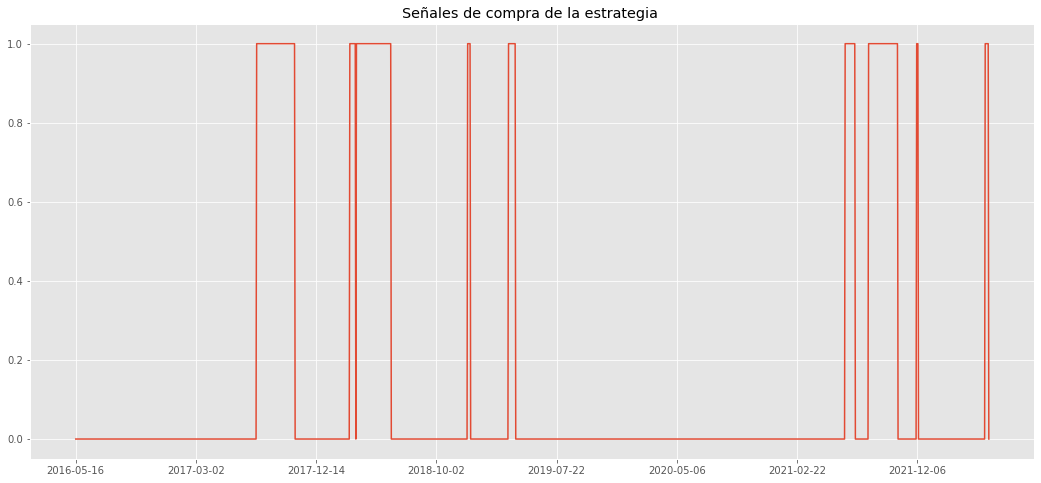

In [17]:
data['Senal'].plot(title = 'Señales de compra de la estrategia ' )
# Ploteando una parte
#data.loc['2010':'2022','Senal'].plot(title = 'Señales Regresión a la media ' +instrumento,xlim=('2010','2022'))

In [18]:
tiempo_final = time() 
 
tiempo_ejecucion = (tiempo_final - tiempo_inicial)/60
 
print ('El tiempo de ejecucion fue:',tiempo_ejecucion,"minutos") #En segundos

El tiempo de ejecucion fue: 12.047236263751984 minutos


In [19]:
data.loc['2011-01-04':'2019-11-04']

,Date,Senal,Price,Objetivo,ExitReason,Beneficio
2016-05-16,2016-05-16,0,137.229996,NaN,NaN,NaN
2016-05-17,2016-05-17,0,136.210007,NaN,NaN,NaN
2016-05-18,2016-05-18,0,136.080002,NaN,NaN,NaN
2016-05-19,2016-05-19,0,133.789993,NaN,NaN,NaN
2016-05-20,2016-05-20,0,135.729996,NaN,NaN,NaN
...,...,...,...,...,...,...
2019-10-29,2019-10-29,0,272.640015,NaN,NaN,NaN
2019-10-30,2019-10-30,0,273.459991,NaN,NaN,NaN
2019-10-31,2019-10-31,0,269.079987,NaN,NaN,NaN
2019-11-01,2019-11-01,0,270.75,NaN,NaN,NaN


In [20]:
#Guardamos el resultado del analisis en un pickle
#dff.to_pickle("./primerBack_IBE.pkl")

***3.- Ingeniería de datos para calcular la bondad de la estrategia***

In [21]:

data['Dif_Close'] = data.Price.pct_change()
data['Retornos'] = data.Dif_Close * data.Senal.shift(1)   
data['Capital'] = (data.Retornos + 1).cumprod() * 100
    
rg.StrategyClass.dfLog=data  #Ojo a esta liena, no me cuadra.

#quant_j.salvarExcel(StrategyClass.dfLog, "log"+instrumento)   
#data.to_pickle('almacen')    #df = pd.read_pickle(file_name)

>Para calcular los retornos del sistema, calculamos la diferencia relativativa entre el precio de cierre y el del día anterior. Para posteriormente multiplicarlo por la señal que del día anterior que nos indicaba la posición a tomar (si estaba comprado, sumo beneficio).

In [22]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2022-05-20,2022-05-20,1,492.850006,NaN,NaN,NaN,0.026942,0.026942,132.668589
2022-05-23,2022-05-23,1,494.850006,NaN,NaN,NaN,0.004058,0.004058,133.206963
2022-05-24,2022-05-24,1,505.290009,NaN,NaN,NaN,0.021097,0.021097,136.017271
2022-05-25,2022-05-25,1,504.779999,NaN,NaN,NaN,-0.001009,-0.001009,135.879983
2022-05-26,2022-05-26,0,512.429993,NaN,1,NaN,0.015155,0.015155,137.939258


In [23]:
data[60:]

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2016-08-10,2016-08-10,0,128.149994,NaN,NaN,NaN,-0.002336,-0.0,100.0
2016-08-11,2016-08-11,0,128.199997,NaN,NaN,NaN,0.000390,0.0,100.0
2016-08-12,2016-08-12,0,130.190002,NaN,NaN,NaN,0.015523,0.0,100.0
2016-08-15,2016-08-15,0,129.289993,NaN,NaN,NaN,-0.006913,-0.0,100.0
2016-08-16,2016-08-16,0,129.330002,NaN,NaN,NaN,0.000309,0.0,100.0
...,...,...,...,...,...,...,...,...,...
2022-05-20,2022-05-20,1,492.850006,NaN,NaN,NaN,0.026942,0.026942,132.668589
2022-05-23,2022-05-23,1,494.850006,NaN,NaN,NaN,0.004058,0.004058,133.206963
2022-05-24,2022-05-24,1,505.290009,NaN,NaN,NaN,0.021097,0.021097,136.017271
2022-05-25,2022-05-25,1,504.779999,NaN,NaN,NaN,-0.001009,-0.001009,135.879983


>El capital, por comodidad, lo calcularemos en base 100, es decir como si iniciaramos la inversión con 100 unidades monetarias. Para su calculo arrastramos el producto acumulado de los retornos mas 1, multiplicados como dijimos por 100.

Pero para observar gráficamente la evolución del sistema necesitamos un gráfico con mas información. Para ello definimos una función que nos mostrará un gráfico con la evolución de nuestra estrategia, comparandola con la del activo. En un subgráfico se visualizará el drawdown del sistema, comparado de nuevo con el del activo. Y por útlimo las posiciones que toma el sistema.

In [24]:
def grafico (df):
    estudio = df.copy()
    
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    #Primer plot analiza la evolcuion de una inversion de 100€ en buy&hold y la estrategia)
    ax1.plot(estudio.Capital)
    ax1.plot((estudio.Price) * (100/estudio.Price[1]))
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    #ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

In [25]:
print(instrumento)

ANTM


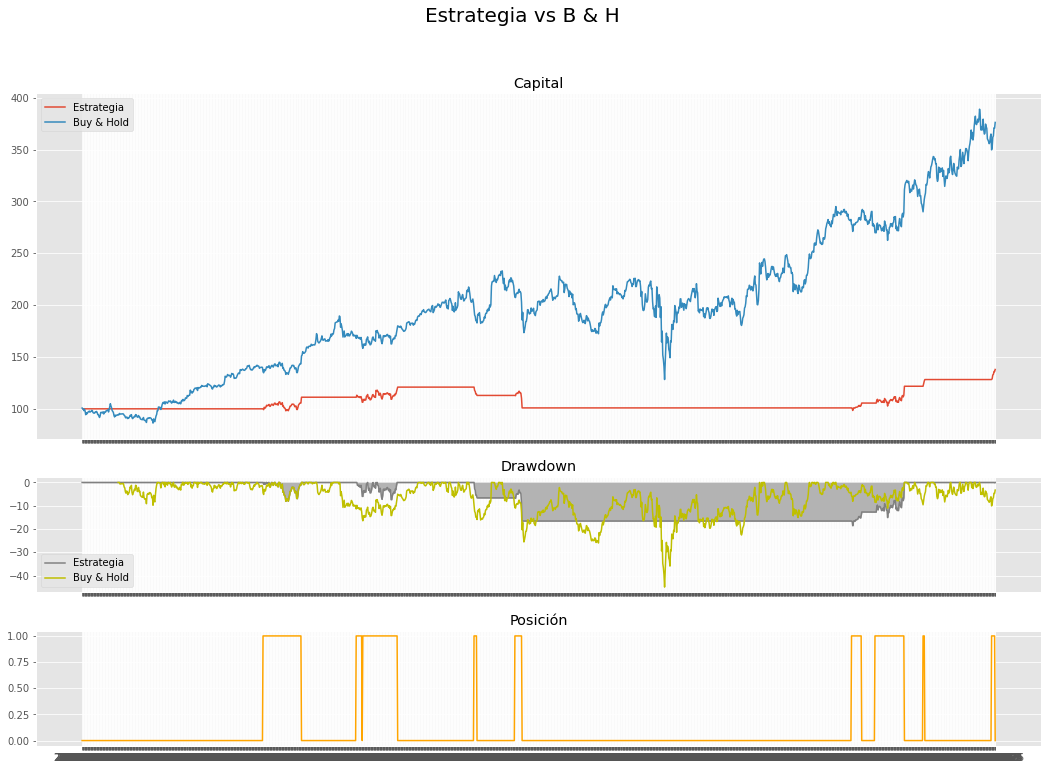

In [26]:
grafico(data)

---

In [27]:
#data[55:70]

---

# ANALISIS DEL SISTEMA

In [28]:
Beneficio_Bruto = data.Capital[-1] - data.Capital[1]
print ('Beneficio Bruto : {:.2f} €  con una inverison de 100€'.format(Beneficio_Bruto))

Beneficio Bruto : 37.94 €  con una inverison de 100€


In [29]:
#Rentabilidad anual compuesta. Calculamos lo que la inversion se ha incrementado cada año con el interes compuesto
CAGR = analisis.CAGR(data.Retornos)
print ('CAGR : {:.2f}%'.format(CAGR * 100))

CAGR : 5.48%


In [30]:
#Ratio calculado restando una rentabilidad segura a nuestra rentabilidad de estrategia y dividido por el riego (=volatilidad)
data.Retornos=data.Retornos.replace(0,np.e)  #Quito los cero (no sepuede hacer logariotmo de cero), pero no se que poner
Sharpe = CAGR / (np.log(data.Retornos + 1).std(skipna=True) * 252 ** 0.5)
print ('Sharpe : {:.3f}'.format(CAGR ))

Sharpe : 0.055


In [31]:
# Actualizo la excel con los economic
regreMedia.analisisEconomics(instrumento)

---


In [32]:
# 

### Cálculo esperanza matemática
 
 (%Aciertos * beneficioMedio )-(%Errores * perdidaMedia)
 Nos da idea el benefcio esperado por entrada

In [33]:
print("Numero operaciones con beneficio ->", 
      data[data['ExitReason'] > 0]['ExitReason'].count()) 
print("Numero operaciones con perdidas ->", 
      data[data['ExitReason'] < 0]['ExitReason'].count()) 
  
data[data['ExitReason']>0]['ExitReason'] 

data[data['Senal']>0][1:10]
data[data['Senal']>0].index[1]

Numero operaciones con beneficio -> 6
Numero operaciones con perdidas -> 16


'2017-07-27'

In [34]:
# ENTRADAS
print (data[(data['Senal']>0) & (data['Beneficio']>0)].index[0])
data[(data['Senal']>0) & (data['Beneficio']>0) ][0:5] 
# SALIDA PERDIDAS
print (data[(data['Senal'].shift(1) >0) & (data['ExitReason']== -1)].index[0])
data[(data['Senal'].shift(1) >0) & (data['ExitReason']== -1)][0:5]
# SALIDA GANANCIAS
data[(data['Senal'].shift(1) >0) & (data['ExitReason']== 1)][0:5]

2017-07-26
2018-03-22


,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2017-10-25,2017-10-25,0,205.710007,NaN,1,NaN,0.053572,0.053572,111.200606
2018-06-15,2018-06-15,0,245.160004,NaN,1,NaN,0.014147,0.014147,120.936422
2021-07-12,2021-07-12,0,396.040009,NaN,1,NaN,0.019119,0.019119,105.573957
2021-10-20,2021-10-20,0,424.049988,NaN,1,NaN,0.076952,0.076952,121.773021
2021-12-08,2021-12-08,0,415.970001,NaN,1,NaN,0.011502,0.011502,128.237781


In [35]:
serieIndicesENTRADA=data[(data['Senal']>0) & (data['Beneficio']>0)].index

print(serieIndicesENTRADA.size)

serieIndicesENTRADA

serieIndicesEXIT=data[(data['ExitReason']==1) | (data['ExitReason']==-1)].index

print(serieIndicesEXIT.size)

#data['ExitReason'][serieIndicesEXIT[2]]

9
9


In [36]:
serieIndicesENTRADA

Index(['2017-07-26', '2018-03-08', '2018-03-23', '2018-12-17', '2019-03-27',
       '2021-06-16', '2021-08-11', '2021-12-03', '2022-05-18'],
      dtype='object')

In [37]:
#Cálculo Esperanza Matemática
countGanando=0
countPerdiendo=0

bolsaGanando=0
bolsaPerdiendo=0

for i in range(serieIndicesEXIT.size):
    if(data['ExitReason'][serieIndicesEXIT[i]] == -1):
        ref1  = data['Price'][serieIndicesEXIT[i]]
        ref2 = data['Price'][serieIndicesENTRADA[i]]
        #print ("-1",ref1, ref2)
        countPerdiendo= 1+countPerdiendo
        bolsaPerdiendo= bolsaPerdiendo + (ref1-ref2)

    
    if(data['ExitReason'][serieIndicesEXIT[i]] == 1):
        ref1  = data['Price'][serieIndicesEXIT[i]]
        ref2 = data['Price'][serieIndicesENTRADA[i]]
        print ("+1",ref1, ref2)
        countGanando= 1+countGanando
        bolsaGanando= bolsaGanando + (ref1-ref2)
    
#(%Aciertos * beneficioMedio )-(%Errores * perdidaMedia)

count=countGanando+countPerdiendo


print ("total ganado   --> ", bolsaGanando, "   numero operaciones ganando   ", countGanando)   
print ("total perdido -->", bolsaPerdiendo, "   numero operaciones perdiendo", countPerdiendo) 
print ("media perdiendo --> ", (bolsaPerdiendo/countPerdiendo), "  media ganando", (bolsaGanando/countGanando)) 


esperanza = (countGanando/count *(bolsaGanando/countGanando))+(countPerdiendo/count *(bolsaPerdiendo/countPerdiendo))
print("")
print("ESPERANZA MATEMATICA ES: ", esperanza)



+1 205.7100067138672 184.99000549316406
+1 245.16000366210938 215.6300048828125
+1 396.0400085449219 378.45001220703125
+1 424.04998779296875 367.6400146484375
+1 415.9700012207031 395.0
+1 512.4299926757812 476.3900146484375
total ganado   -->  181.25994873046875    numero operaciones ganando    6
total perdido --> -57.77998352050781    numero operaciones perdiendo 3
media perdiendo -->  -19.259994506835938   media ganando 30.209991455078125

ESPERANZA MATEMATICA ES:  13.719996134440102


---

In [38]:
serieIndicesEXIT

Index(['2017-10-25', '2018-03-22', '2018-06-15', '2018-12-24', '2019-04-12',
       '2021-07-12', '2021-10-20', '2021-12-08', '2022-05-26'],
      dtype='object')

In [39]:
serieIndicesENTRADA

Index(['2017-07-26', '2018-03-08', '2018-03-23', '2018-12-17', '2019-03-27',
       '2021-06-16', '2021-08-11', '2021-12-03', '2022-05-18'],
      dtype='object')